In [1]:
import pandas as pd
df_cleaned = pd.read_csv("../../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military"
  ]
df_filtered = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df_filtered.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [2]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
stop_words_path = "./../SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    return tokens


stopwords = load_stop_words()
df_filtered.loc[:, "text"] = df_filtered["text"].apply(lambda text: preprocess_text(text, stopwords))
df_filtered = df_filtered[df_filtered["text"] != ""]

In [3]:
topics = {
    "National Security, Defence, Foreign Affairs": 0, 
    "Health Care and Social Security": 1, 
    "Energy and Environment": 2, 
    "Jobs and the Economy": 3,
				"Education": 4, 
				"Veterans and Military": 5, 
}
    

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
df_filtered['issue'] = label_encoder.fit_transform(df_filtered['issue'])

df = df_filtered.copy()
num_classes = len(label_encoder.classes_)
y = to_categorical(df['issue'], num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(df["text"], y, test_size=0.2,
                                                    random_state=42)
X_train[0]


2024-11-21 03:26:44.632529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732156004.646355  519878 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732156004.650287  519878 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 03:26:44.666568: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['washington',
 'today',
 'congressman',
 'brad',
 'sherman',
 'ca',
 'senior',
 'member',
 'house',
 'foreign',
 'affair',
 'committee',
 'chair',
 'house',
 'israel',
 'allied',
 'caucus',
 'released',
 'statement',
 'israeli',
 'military',
 'rescue',
 'israeli',
 'arab',
 'hamas',
 'captivity',
 'grueling',
 'month',
 'israel',
 'risked',
 'life',
 'soldier',
 'rescue',
 'hostage',
 'held',
 'captive',
 'hamas',
 'today',
 'bravery',
 'secured',
 'rescue',
 'qaid',
 'farhan',
 'alkadi',
 'year',
 'father',
 'member',
 'israel',
 'arab',
 'bedouin',
 'community',
 'rare',
 'moment',
 'joy',
 'made',
 'israel',
 'indiscriminate',
 'zeal',
 'justice',
 'stark',
 'reminder',
 'work',
 'remains',
 'bring',
 'hostage',
 'home',
 'today',
 'rescue',
 'qaid',
 'farhan',
 'alkadi',
 'eighth',
 'hostage',
 'rescued',
 'alive',
 'approximately',
 'abducted',
 'month',
 'ago',
 'israeli',
 'arab',
 'hostage',
 'rescued',
 'alive',
 'october']

In [5]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input length
max_length = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [6]:
import gensim as gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors
import os.path

WORKERS = 14        #Number of threads to use for embedding model training

def get_embedding_model(name, path):
    if name != "CUSTOM":
        if not os.path.exists(path):
            word2vec_model = api.load(name)
            word2vec_model.save_word2vec_format(path)
        else:
            word2vec_model = KeyedVectors.load_word2vec_format(path, binary=False)
    else:
        word2vec_model = get_custom_embedding_model(VECTOR_SIZE, WINDOW_SIZE, X_train)
    return word2vec_model

def get_custom_embedding_model(size, window, x_train):
    word2vec_model = Word2Vec(x_train, vector_size=size, window=window, min_count=1, workers=WORKERS)
    return word2vec_model.wv

print("Available models:\n", list(api.info()['models'].keys()))

Available models:
 ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [7]:
WINDOW_SIZE = 5                                 # For custom model only
VECTOR_SIZE = 200                               # Fill even if using custom model
MODEL_NAME = 'CUSTOM'                           # "CUSTOM" for locally trained model
MODELS_PATH = f'./models/{MODEL_NAME}.bin'


word_vectors = get_embedding_model(MODEL_NAME, MODELS_PATH)
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, VECTOR_SIZE))

for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

In [8]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5632)])
    except RuntimeError as e:
        print(e)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=VECTOR_SIZE, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(256, activation='softplus'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='softplus'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam_optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=90, batch_size=64, validation_data=(X_test_pad, y_test))

I0000 00:00:1732156014.472418  519878 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-11-21 03:26:54.487015: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 5.50GiB (5905580032 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 1/90


I0000 00:00:1732156017.799679  520077 service.cc:148] XLA service 0x73c8f8009f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732156017.799704  520077 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-21 03:26:57.823803: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732156017.928612  520077 cuda_dnn.cc:529] Loaded cuDNN version 90501


 19/177 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1866 - loss: 3.4138

I0000 00:00:1732156019.230507  520077 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2877 - loss: 2.3592 - val_accuracy: 0.8259 - val_loss: 0.6969
Epoch 2/90
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5980 - loss: 1.1690 - val_accuracy: 0.8540 - val_loss: 0.5349
Epoch 3/90
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7140 - loss: 0.8966 - val_accuracy: 0.8582 - val_loss: 0.5020
Epoch 4/90
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7777 - loss: 0.7130 - val_accuracy: 0.8607 - val_loss: 0.4967
Epoch 5/90
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8222 - loss: 0.5842 - val_accuracy: 0.8678 - val_loss: 0.5021
Epoch 6/90
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8468 - loss: 0.5283 - val_accuracy: 0.8628 - val_loss: 0.5299
Epoch 7/90
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8842 - loss: 0.3855 - val_accuracy: 0.8642 - val_loss: 0.5591
Epoch 8/90
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9000 - loss: 0.3510 - val_accuracy: 0.8625 - va

In [12]:
from sklearn.metrics import f1_score, accuracy_score

probs = model.predict(X_test_pad)
y_pred = np.argmax(probs, axis=1)

y_true = np.argmax(y_test, axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

print("Accuracy: ", accuracy_score(y_true, y_pred), " | F1 score: ", f1_score(y_true, y_pred, average='micro'))


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy:  0.8546614675646934  | F1 score:  0.8546614675646934


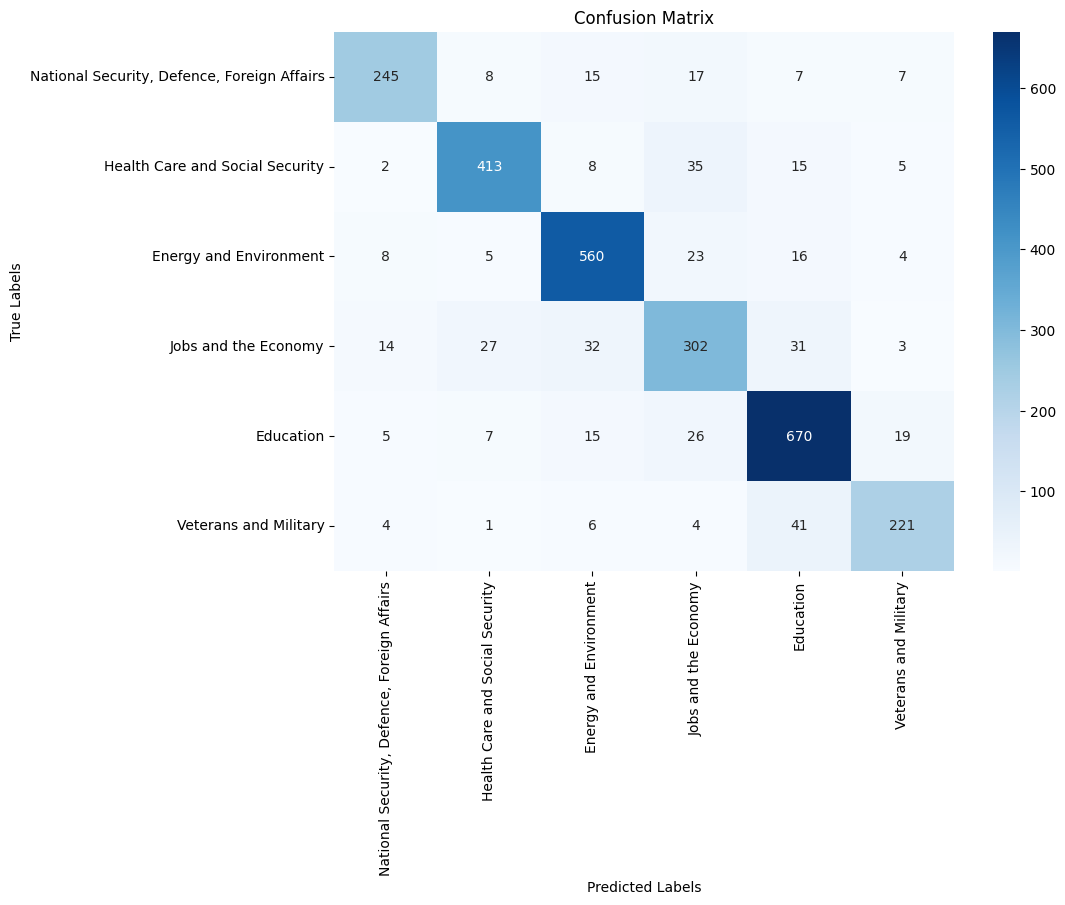

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=topics.keys(), 
            yticklabels=topics.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()